In [1]:
import sys
music_gen_path = "/home/henri/Documents/Git/MusicGenerationWithML"
if music_gen_path not in sys.path:
    sys.path.append(music_gen_path)
import numpy as np
from util.music_theory import *
from util.sixteenth_array import *
from util.music_parsing import *
#import file_management import midi_index
from file_management import midi_index
from music_generation.random_generate import *
import pandas as pd
from music_rating.feature_extraction import *
import matplotlib.pyplot as plt
import matplotlib
import pickle

#hello = randomlyGenerateBar2()
#hi = hello.toSong()

Directory changed to /home/henri/Documents/Git/MusicGenerationWithML
File data/MUSICFILEINDEX.csv exists


In [2]:
#midi_index.update()

# Helper Functions

In [157]:
def histogram(l, title=""):
    plt.hist(l, bins=20)
    ax = plt.axes()
    ax.set_title(title)
    plt.show()
    
def histograms(values_list, title_list, width=2):
    assert(len(values_list) == len(title_list))
    
    n_rows = (len(values_list) + width - 1) / width
    f, (axs) = plt.subplots(n_rows, width)
    
    for ax, values, title in zip(axs, values_list, title_list):
        ax.hist(values, bins=20)
        ax.set_title(title)
        
    plt.show()

def tryPolicy(env, policy_fn, observationToStateFn=lambda x:x, n_episodes=20, max_episode_len=100):
    returns = []
    #episode_lengths = []
    generated_music = []
    
    for i_episode in range(n_episodes):
        observation = env.reset()
        episode_len = max_episode_len
        reward_sum = 0
        for t in range(episode_len):
            state = observationToStateFn(observation)
            action_probs = policy_fn(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            observation, reward, done, info = env.step(action)
            reward_sum += reward
            if done:
                episode_len = t+1
                generated_music.append(tuple(env.melody_arr))
                break
        #episode_lengths.append(episode_len)
        returns.append(reward_sum)
    return returns, generated_music

def pickleSave(var, file_path):
    # known errors:
    # - defaultdict doesn't work when it uses lambda functions
    # - defaultdict can give strange errors; save dict(varr) instead
    # - "import reinforcement_learning as rl" syntax (use "from ... import ..." instead)
    if not file_path.endswith('.p'):
        file_path += '.p'
    pickle.dump(var, open(file_path, "wb"))
    
def pickleLoad(file_path):
    if not file_path.endswith('.p'):
        file_path += '.p'
    return pickle.load(open(file_path, "rb"))

# Train Music Rating Model

In [4]:
PLT_COLOURS = ['g', 'r', 'c', 'b', 'm', 'y', 'k']
# scatter plot input specification:
#  - x_values, y_values: list of numbers (same size)
#  - labels: same size as x_values or an empty list
#  - x_label, y_label, and title: string
def scatter(x_values, y_values, labels=[], x_label="", y_label="", title=""): 
    if len(labels) == 0:
        plt.plot(x_values, y_values, 'o')
    else:
        distinct_labels = set(labels)
   
        if len(distinct_labels) > len(PLT_COLOURS):
            raise Exception("Too many labels: {} > {}".format(len(distinct_labels), len(PLT_COLOURS)))
       
        # group by label
        label_dict = dict([(key, []) for key in distinct_labels])
        for x, y, label in zip(x_values, y_values, labels):
            label_dict[label].append((x, y))

        # iterate by label
        label_to_index = dict([(label, i) for i, label in enumerate(distinct_labels)])
        handles = []
        for label in label_dict.keys():
            values = label_dict[label]
            label_x_values, label_y_values = zip(*values)
            #label_x_values, label_y_values
            colour = PLT_COLOURS[label_to_index[label]]
           
            scatter_handle = plt.scatter(label_x_values, label_y_values, label=label,
                    c=colour, cmap=matplotlib.colors.ListedColormap(PLT_COLOURS))
            handles.append(scatter_handle)
       
        plt.legend(handles=handles)
 
    ax = plt.axes()
    if title != "":
        ax.set_title(title)
    if x_label != "":
        ax.set_xlabel(x_label)
    if y_label != "":
        ax.set_ylabel(y_label)
    plt.show()

In [5]:
file_path = 'data/MusicRatingData.csv'
df = pd.read_csv(file_path, header=0)
df

,file_path,part,real_music,#_direction_changes,ratio_non_ct_step_from_ct,ratio_longest_note_in_chord,interval_occurrence_dot_prod,ratio_non_ct_step_to_ct,ratio_notes_fitting_chord,ratio_ct_reached,...,interval_distance_median,last_note_in_chord,pickup_beat_len,start_rest_len,max_interval_duration_ratio,interval_skewness,n_distinct_pitches,leap_proportion,ratio_tonic_of_chord_reached,max_note_break
0,data/generated_randomly/randomly_generated_2.mid,0,0,1,0.166667,1.000000,13,0.166667,0.333333,1.000000,...,3.0,1,0.0,0.0,4,-0.271545,5,0.600000,1.000000,4
1,data/generated_randomly/randomly_generated_2.mid,1,0,1,0.000000,0.000000,19,0.000000,0.400000,1.000000,...,3.5,0,0.0,0.0,1,1.065949,4,1.000000,1.000000,6
2,data/generated_randomly/randomly_generated_2.mid,2,0,0,0.000000,1.000000,16,0.000000,0.833333,1.000000,...,4.0,1,0.0,0.0,0,-0.039969,4,0.600000,1.000000,4
3,data/generated_randomly/randomly_generated_2.mid,3,0,1,0.142857,0.000000,13,0.142857,0.857143,1.000000,...,1.5,1,0.0,0.0,2,0.415104,4,0.333333,1.000000,4
4,data/generated_randomly/randomly_generated_2.mid,4,0,0,0.000000,0.000000,12,0.000000,0.000000,0.000000,...,1.5,0,3.0,1.0,1,0.816497,3,0.500000,0.000000,4
5,data/generated_randomly/randomly_generated_2.mid,5,0,2,0.000000,0.000000,13,0.142857,0.714286,1.000000,...,2.5,1,0.0,0.0,1,0.106560,4,0.500000,0.000000,4
6,data/generated_randomly/randomly_generated_2.mid,6,0,1,0.142857,1.000000,17,0.285714,0.571429,1.000000,...,2.0,0,0.0,0.0,2,0.624860,5,0.333333,0.000000,4
7,data/generated_randomly/randomly_generated_2.mid,7,0,0,0.400000,1.000000,15,0.200000,0.600000,1.000000,...,2.0,1,0.0,0.0,2,1.109968,5,0.250000,0.000000,4
8,data/generated_randomly/randomly_generated_2.mid,8,0,3,0.166667,0.000000,15,0.166667,0.500000,1.000000,...,3.0,1,0.0,0.0,2,0.000000,5,0.600000,1.000000,4
9,data/generated_randomly/randomly_generated_2.mid,9,0,2,0.000000,0.000000,15,0.000000,0.000000,0.000000,...,3.0,0,0.0,0.0,1,0.000000,3,0.600000,0.000000,4


In [6]:
columns = "file_path,part,real_music,#_direction_changes,ratio_non_ct_step_from_ct,ratio_longest_note_in_chord,interval_occurrence_dot_prod,ratio_non_ct_step_to_ct,ratio_notes_fitting_chord,ratio_ct_reached,total_melody_distance,ratio_notes_fitting_chord_w_duration,total_leap_distance,n_notes,n_bars,is_major,max_interval,interval_distance_median,last_note_in_chord,pickup_beat_len,start_rest_len,max_interval_duration_ratio,interval_skewness,n_distinct_pitches,leap_proportion,ratio_tonic_of_chord_reached,max_note_break"
remove_columns = "file_path,is_major,part" #+ ",ratio_ct_reached,ratio_longest_note_in_chord,max_note_break"
mutate_columns = "total_melody_distance,total_leap_distance,n_notes,n_bars,pickup_beat_len,#_direction_changes"
label_column = "real_music"

In [15]:
def minMaxScaler(data):
    m = min(data)
    M = max(data)
    if m == M:
        print "Warning: {} = {}".format(m, M)
        return data
    else:
        return (np.array(data) - m) / float(M - m)

def preprocessData(df):
    df_null = df[df.isnull().any(axis=1)]
    df_null_len =  len(df_null.index) 
    if df_null_len > 0:
        print df_null_len, "rows with null values"
        print(df_null)
        
    df = df[df.notnull().all(axis=1)]
    
    for col in remove_columns.split(","):
        del df[col]
    
    # create new features
    n_bars = np.array(df["n_bars"].values)
    pickup_beat_len = np.array(df["pickup_beat_len"].values)
    n_beats = (n_bars * 4).astype(float)
    # adjust for pickup
    n_beats[pickup_beat_len >= .01] -= 4 - pickup_beat_len[pickup_beat_len >= .01]

    df["total_melody_distance_per_beat"] = df["total_melody_distance"] / n_beats
    df["total_leap_distance_per_beat"] = df["total_leap_distance"] / n_beats
    df["n_notes_per_beat"] = df["total_leap_distance"] / n_beats
    df["#_direction_changes_per_beat"] = df["#_direction_changes"] / n_beats
    #df["ratio_close_ct"] = df["ratio_notes_fitting_chord"] + df["ratio_non_ct_step_from_ct"] + df["ratio_non_ct_step_to_ct"]
    
    for col in mutate_columns.split(","):
        del df[col]
    
    labels = df[label_column].values
    del df[label_column]
    
    mins = np.array(map(lambda col: min(df[col].values), df.columns.values))
    maxes = np.array(map(lambda col: max(df[col].values), df.columns.values))
    
    for col in df.columns.values:
        df[col] = minMaxScaler(df[col].values)
    
    data = df.as_matrix()
    
    null_data_rows = np.argwhere(np.isnan(data))
    if len(null_data_rows) > 0:
        raise Exception("Rows are still null: {}".format(null_data_rows))
    
    return data, labels, df.columns.values, df, mins, maxes

data, labels, features, df2, mins, maxes = preprocessData(df)
data, labels, len(labels)

1 rows with null values
                                           file_path  part  real_music  \
77  data/generated_randomly/randomly_generated_2.mid    77           0   

    #_direction_changes  ratio_non_ct_step_from_ct  \
77                    1                        0.0   

    ratio_longest_note_in_chord  interval_occurrence_dot_prod  \
77                          0.0                            15   

    ratio_non_ct_step_to_ct  ratio_notes_fitting_chord  ratio_ct_reached  \
77                      0.0                       0.25               1.0   

         ...        interval_distance_median  last_note_in_chord  \
77       ...                             5.0                   1   

    pickup_beat_len  start_rest_len  max_interval_duration_ratio  \
77              0.0             0.0                            1   

    interval_skewness  n_distinct_pitches  leap_proportion  \
77                NaN                   3              1.0   

    ratio_tonic_of_chord_reached  m

/home/henri/Documents/MachineLearning/venv/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/henri/Documents/MachineLearning/venv/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/henri/Documents/MachineLearning/venv/lib/python2.7/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

(array([[ 0.41666667,  1.        ,  0.00571429, ...,  0.08282379,
          0.08282379,  0.16666667],
        [ 0.        ,  0.        ,  0.04      , ...,  0.16536965,
          0.16536965,  0.16666667],
        [ 0.        ,  1.        ,  0.02285714, ...,  0.13785436,
          0.13785436,  0.        ],
        ..., 
        [ 0.46296296,  0.5       ,  0.20571429, ...,  0.01808194,
          0.01808194,  0.21568627],
        [ 0.13513514,  0.66666667,  0.36      , ...,  0.08740967,
          0.08740967,  0.38888889],
        [ 0.625     ,  0.66666667,  0.25142857, ...,  0.06684717,
          0.06684717,  0.47311828]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [16]:
#def splitData(df, split=[0.6, 0.2, 0.2]):
#    train_frac = split[0]
#    train_and_valid_frac = split[0] + split[1]
#    return np.split(df.sample(frac=1), [int(split[0]*len(df)), int(train_and_valid_frac*len(df))])
from sklearn.model_selection import train_test_split
def splitData(data, labels, split=[0.6, 0.2, 0.2]):
    x, x_test, y, y_test = train_test_split(data,labels,test_size=split[2],train_size=(1-split[2]))
    train_and_validation = split[0] + split[1]
    train = split[0]
    train_validation_ratio = train / train_and_validation
    x_train, x_cv, y_train, y_cv = train_test_split(
        x,y,test_size = 1-train_validation_ratio,train_size = train_validation_ratio)
    
    return zip(x_train, y_train), zip(x_cv, y_cv), zip(x_test, y_test)


#train, validation, test = splitData(df2, split=[0.6, 0.2, 0.2])
train, validation, test = splitData(data, labels, split=[0.6, 0.4, 0.2])

In [17]:
#len(train.index), len(validation.index), len(test.index)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=100)

In [19]:
clf.fit(*zip(*train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [20]:
clf.predict(data)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0])

In [21]:
print "All:", accuracy_score(clf.predict(data), labels)
print "Train:", accuracy_score(clf.predict(zip(*train)[0]), zip(*train)[1])
print "Validation:", accuracy_score(clf.predict(zip(*validation)[0]), zip(*validation)[1])
print "Test:", accuracy_score(clf.predict(zip(*test)[0]), zip(*test)[1])

All: 0.971929824561
Train: 1.0
Validation: 0.934782608696
Test: 0.964912280702


In [22]:
sorted(zip(clf.feature_importances_, features), reverse=True)

[(0.11793789494503205, 'total_melody_distance_per_beat'),
 (0.1002510439900563, 'ratio_notes_fitting_chord_w_duration'),
 (0.099811113053648523, 'max_note_break'),
 (0.094027256438795406, 'start_rest_len'),
 (0.074392573968851405, 'interval_skewness'),
 (0.067933138834154638, 'max_interval_duration_ratio'),
 (0.064994745071489515, 'n_distinct_pitches'),
 (0.063741968427632648, 'total_leap_distance_per_beat'),
 (0.061568415875385758, 'n_notes_per_beat'),
 (0.052282719901617244, 'interval_occurrence_dot_prod'),
 (0.048963831455084025, 'leap_proportion'),
 (0.044178721059311504, 'interval_distance_median'),
 (0.029603687418034631, 'ratio_notes_fitting_chord'),
 (0.018356829122554982, 'ratio_tonic_of_chord_reached'),
 (0.012917246469201589, 'max_min_distance'),
 (0.012033387092230927, 'ratio_non_ct_step_from_ct'),
 (0.0090372864983194676, 'ratio_longest_note_in_chord'),
 (0.0078612324263952326, 'ratio_non_ct_step_to_ct'),
 (0.0075560332002162891, '#_direction_changes_per_beat'),
 (0.005829

In [23]:
from sklearn.decomposition import PCA

In [24]:
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)
data_2d

array([[-0.68264661, -0.67086653],
       [-0.19717641,  0.65847078],
       [-0.33859682, -0.86320449],
       [-0.83893132, -0.22534836],
       [-0.62267585,  1.03923296],
       [-0.870271  ,  0.03526694],
       [-0.68816766,  0.10446287],
       [-0.87226454, -0.63142173],
       [-0.67432584, -0.08053337],
       [-0.62514609,  1.07370607],
       [-0.62760565, -0.75716474],
       [-0.00732238, -0.93444744],
       [-0.12749456,  0.8900584 ],
       [-0.40030535,  0.01672251],
       [-0.44696086,  0.06256171],
       [-0.19428336, -0.81925827],
       [-0.77300467,  0.67516149],
       [-0.64000615, -0.50622594],
       [-0.48637967,  0.02480146],
       [-0.40966558, -0.85171328],
       [-0.45403711,  1.05558621],
       [-0.44979384,  0.62835104],
       [-0.15000855, -0.09855918],
       [-0.71207379, -0.11687999],
       [-0.22933243, -0.05196476],
       [-0.61331335, -0.48639266],
       [-0.48312141, -0.01213171],
       [-0.46268967, -0.66800206],
       [-0.43797376,

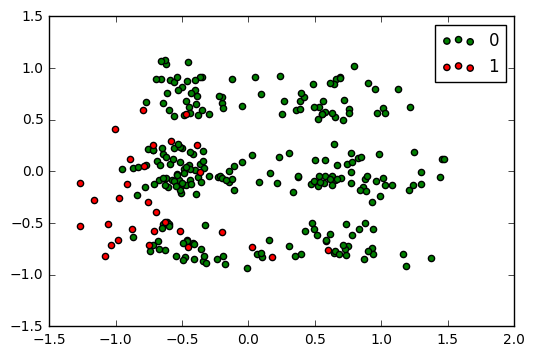

In [25]:
scatter(data_2d[:,0], data_2d[:,1], labels)

In [26]:
#from sklearn.manifold import TSNE
#data_tsne = TSNE(n_components=2, random_state=0).fit(data).transform(data)
#scatter(data_tsne[:,0], data_tsne[:,1], labels)

# Load Existing Mode

In [27]:
from sklearn.externals import joblib
def classifierToFile(clf, file_name):
    if not file_name.endswith(".pkl"):
        file_name += ".pkl"
    joblib.dump(clf, file_name)

def fileToClassifier(file_name):
    return joblib.load(file_name)

In [28]:
classifier_path = "music_rating/music_rating_model.pkl"
#classifierToFile(clf, classifier_path)
clf2 = fileToClassifier(classifier_path)

# Observation Space Histogram

[ 47  37  92  62  62  88  29  71  31  40  99 102 116  49  35  27 130 128
  69  97  56  47  22 187  44  17  45  48  75  56]
[ 15.5  17.5  33.5  16.5  16.5  16.   32.   16.   17.   16.   32.   32.
  15.5   9.    9.    8.    8.   16.   18.   34.    8.   15.5   8.   50.5
  34.   16.5  31.   34.   24.   15.5]


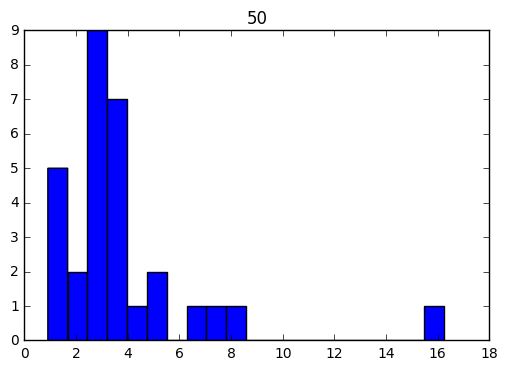

In [29]:
def melodyDistanceHistogram():
    df2 = df[df["real_music"] >= 0.5]
    n_bars = np.array(df2["n_bars"].values)
    pickup_beat_len = np.array(df2["pickup_beat_len"].values)
    n_beats = (n_bars * 4).astype(float)
    # adjust for pickup
    n_beats[pickup_beat_len >= .01] -= 4 - pickup_beat_len[pickup_beat_len >= .01]
    print df2["total_melody_distance"].values
    print n_beats
    
    for_histogram = df2["total_melody_distance"].values / n_beats
    histogram(for_histogram, 50)
melodyDistanceHistogram()

# Environment For RL Agent

In [30]:
POSSIBLE_MIDI_NOTES = map(scaleDegreeToCMajorMidiNum, POSSIBLE_NOTES)

In [31]:
# state converter sanity check
'''
a 0 ... 8
b POSSIBLE_MIDI_NOTES
c 0 ... 15
d 0 ... 8
'''
states = []
for a in range(9):
    for b in POSSIBLE_MIDI_NOTES:
        for c in range(16):
            for d in range(9):
                result = a
                prev_note = cMajorMidiNumToScaleDegree(b) - 5
                result = prev_note + result * 15
                result = prev_note + result * 15
                result = c + result * 16
                result = d + result * 9
                states.append(result)
print len(states), len(set(states))

19440 19440


In [78]:
def sixteenthArrayToDataPoint(sixteenth_arr):
    extracted_features = extractFeatures(sixteenth_arr)
    
    extracted_features["total_melody_distance_per_beat"] = extracted_features["total_melody_distance"] / 4
    extracted_features["total_leap_distance_per_beat"] = extracted_features["total_leap_distance"] / 4
    extracted_features["n_notes_per_beat"] = extracted_features["total_leap_distance"] / 4
    extracted_features["#_direction_changes_per_beat"] = extracted_features["#_direction_changes"] / 4
    
    data = map(lambda col: extracted_features[col], features)
    
    return (data - mins) / (maxes - mins)
    

def sixteenthArrayToModelPrediction(sixteenth_arr):
    data = [sixteenthArrayToDataPoint(sixteenth_arr)]
    chNe(np.sum(data[0]), np.nan, "sixteenthArrayToDataPoint")
    return clf2.predict(data)[0]

In [133]:
class MusicActionSpace:
    def __init__(self):
        self.possible_notes = POSSIBLE_MIDI_NOTES
        self.n = len(self.possible_notes)
    def actionToMidiNum(self, action):
        return self.possible_notes[action]
        

class BasicMusicGenerationEnvironment:
    n_states = 9 * 15 * 16 * 9 + 1
    
    def __init__(self):
        self.action_space = MusicActionSpace()
        
        self.melody_arr = [SUSTAIN] * SIXTEENTH_BAR_LEN
        
        self.harmony_arr = [SUSTAIN] * SIXTEENTH_BAR_LEN
        self.harmony_arr[0] = Harmony('C', '+')
        
        self.sixteenth_arr = SixteenthArray()
        self.sixteenth_arr.loadFromArguments(self.melody_arr, self.harmony_arr)
        
        self.reset()
    
    def reset(self):
        self.note_position = 0 # 0, to 7
        self.prev_note = -1
        self.note_distance = 0
        self.n_chord_tones = 0
        #self.n_leaps = 0
        for i in range(0, SIXTEENTH_BAR_LEN, 2):
            self.melody_arr[i] = SUSTAIN
        return self._getState()
    
    def _getDistanceBin(self):
        result = (self.note_distance * 4) / self.note_position
        result = min(result, 15)
        return result
    
    def _getState(self):
        '''if self.note_position == 0:
            return self.n_states - 1
        else:
            result = self.note_position
            prev_note = cMajorMidiNumToScaleDegree(self.prev_note) - 5
            result = prev_note + result * 15
            result = self._getDistanceBin() + result * 16
            result = self.n_chord_tones + result * 9
            return result'''
        if self.note_position == 0:
            return (0, 0, 0, 0)
        
        prev_note = cMajorMidiNumToScaleDegree(self.prev_note) - 5
        return (self.note_position, prev_note, self._getDistanceBin(),  self.n_chord_tones)
        
    def _printStateVars(self):
        state_variable_names = 'n_chord_tones,note_distance,note_position,prev_note'.split(",")
        state_variables = vars(self)
        for k in state_variable_names:
            print k, ":", state_variables[k]
        print ""
    
    def step(self, action):
        curr_note = self.action_space.actionToMidiNum(action)
        if self.note_position != 0:
            self.note_distance += np.abs(curr_note - self.prev_note)
        self.melody_arr[2 * self.note_position] = curr_note
        self.note_position += 1
        
        if self.harmony_arr[0].fitChord(curr_note):
                self.n_chord_tones += 1
        #if self.note_position > 0 and np.abs(self.prev_note - curr_note) >= LEAP_MIN_DIFF:
        #    self.n_leaps += 1
        self.prev_note = curr_note
        
        if self.note_position < 8:
            reward = 0
            done = False
        else:
            try:
                reward = sixteenthArrayToModelPrediction(self.sixteenth_arr)
                #print "reward:", reward
            except:
                reward = 0
                print "reward failed:"
                print " ", self.sixteenth_arr.melody_arr
                print features
                print sixteenthArrayToDataPoint(self.sixteenth_arr)
                #raise Exception("stop")
            
            done = True
            
        next_state = self._getState()
        
        #self._printStateVars()

        #     object,      float,  boolean, dictionary
        #     observation, reward, done, info
        return next_state, reward, done, {}

# Reinforcement Learning Algorithm

In [134]:
env = BasicMusicGenerationEnvironment()

In [135]:
from music_generation.reinforcement_learning import mcControlEpsilonGreedy
Q, policy = mcControlEpsilonGreedy(env, num_episodes=50000, epsilon=0.1)

/home/henri/Documents/MachineLearning/venv/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in long_scalars


Episode 1000/50000.
Episode 2000/50000.
Episode 3000/50000.
Episode 4000/50000.
Episode 5000/50000.
Episode 6000/50000.
Episode 7000/50000.
Episode 8000/50000.
Episode 9000/50000.
Episode 10000/50000.
Episode 11000/50000.
Episode 12000/50000.
Episode 13000/50000.
Episode 14000/50000.
Episode 15000/50000.
Episode 16000/50000.
Episode 17000/50000.
Episode 18000/50000.
Episode 19000/50000.
Episode 20000/50000.
Episode 21000/50000.
Episode 22000/50000.
Episode 23000/50000.
Episode 24000/50000.
Episode 25000/50000.
Episode 26000/50000.
Episode 27000/50000.
Episode 28000/50000.
Episode 29000/50000.
Episode 30000/50000.
Episode 31000/50000.
Episode 32000/50000.
Episode 33000/50000.
Episode 34000/50000.
Episode 35000/50000.
Episode 36000/50000.
Episode 37000/50000.
Episode 38000/50000.
Episode 39000/50000.
Episode 40000/50000.
Episode 41000/50000.
Episode 42000/50000.
Episode 43000/50000.
Episode 44000/50000.
Episode 45000/50000.
Episode 46000/50000.
Episode 47000/50000.
Episode 48000/50000.
E

In [136]:
returns, generated_music = tryPolicy(
    env, policy, n_episodes=100, max_episode_len=300)

/home/henri/Documents/MachineLearning/venv/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in long_scalars


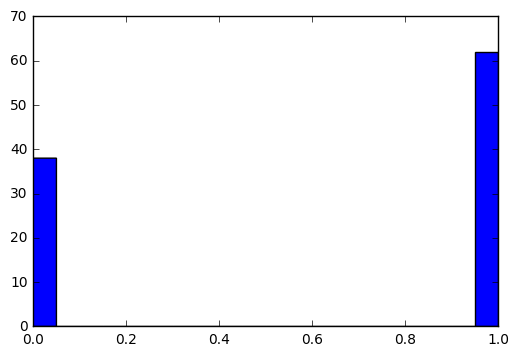

In [137]:
histogram(returns)

In [149]:
from collections import defaultdict
from music_generation.reinforcement_learning import makeQDefaultDictFn

model_path = 'music_generation/Q-1-epsilon-greedy-50000-iters-discount-1'
pickleSave(dict(Q), model_path)
Q = pickleLoad(model_path)
Q = defaultdict(makeQDefaultDictFn(env), Q)

# Discount 0.9, 10000 Iters, Exploration

In [150]:
def makeExploringDefaultDictFn(env):
    def exploringDefaultDictFn():
        return np.ones(env.action_space.n) * 2
    return exploringDefaultDictFn


In [152]:
Q = defaultdict(makeExploringDefaultDictFn(env))
Q, policy = mcControlEpsilonGreedy(
    env, default_Q=Q, num_episodes=10000, discount_factor=0.9, epsilon=0.1)

/home/henri/Documents/MachineLearning/venv/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in long_scalars


Episode 1000/10000.
Episode 2000/10000.
Episode 3000/10000.
Episode 4000/10000.
Episode 5000/10000.
Episode 6000/10000.
Episode 7000/10000.
Episode 8000/10000.
Episode 9000/10000.
Episode 10000/10000.


In [158]:
returns, generated_music = tryPolicy(
    env, policy, n_episodes=100)

/home/henri/Documents/MachineLearning/venv/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in long_scalars


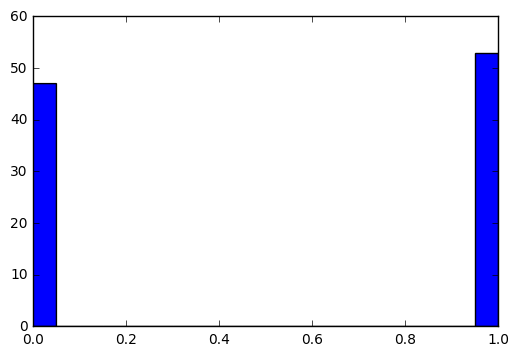

In [156]:
histogram(returns)

In [169]:
returns = np.array(returns)
generated_music = np.array(generated_music)
good_music = map(tuple, generated_music[returns >= 0.5])
good_music = list(set(good_music))
good_music = np.array(good_music).reshape((-1,))

In [170]:
good_music_len = len(good_music)
harmony_arr = [SUSTAIN] * good_music_len
for i in range(0, good_music_len, SIXTEENTH_BAR_LEN):
    harmony_arr[i] = Harmony('C', '+')

In [172]:
q2_gen = SixteenthArray()
q2_gen.loadFromArguments(good_music, harmony_arr)
q2_gen.toSong().toMidi('data/generated_rl/q2-gen.mid')

In [173]:
model_path = 'music_generation/Q-2-epsilon-greedy-10000-iters-discount-0.9-exploration'
pickleSave(dict(Q), model_path)
Q = pickleLoad(model_path)
Q = defaultdict(makeQDefaultDictFn(env), Q)

## Old

In [2]:
hi.printMe()


bpm: 120
time_sig: [4, 4]
key_sig: C
instrument: 1
ppqn: 480
pulse_len: 1920
bar_len: 1920
melody: [62, 60, 53, 55, 57, 59, 60]
melody_time_intervals: [[0, 240], [240, 480], [480, 720], [720, 1200], [1200, 1440], [1440, 1680], [1680, 1920]]
chords: [<util.music_theory.Harmony instance at 0x2e00950>]
chord_time_intervals: [[0, 1920]]


In [3]:
ola = hi.toSixteenthArray()

In [4]:
#ola.melody_arr

In [3]:
music_path = 'data/midi_my_data/Music_AI_Data.mid'
song = Song()
song.loadFromMidi(music_path)
arr = song.toSixteenthArray()
splitted = arr.splitByBarRest()


In [10]:
song.printMe()

bpm: 120
time_sig: [4, 4]
key_sig: G
instrument: 1
ppqn: 480
pulse_len: 416640
bar_len: 1920
melody: [63, 75, 70, 68, 63, 68, 66, 51, 54, 51, 75, 70, 66, 61, 56, 49, 51, 54, 58, 51, 54, 51, 75, 70, 66, 61, 56, 49, 51, 54, 58, 75, 75, 73, 73, 71, 71, 70, 70, 68, 68, 66, 66, 65, 65, 63, 63, 71, 70, 66, 71, 70, 66, 64, 64, 63, 64, 64, 63, 66, 66, 58, 59, 58, 54, 58, 59, 58, 54, 68, 71, 71, 71, 78, 75, 73, 71, 75, 78, 78, 75, 73, 71, 68, 71, 75, 73, 71, 71, 68, 75, 73, 71, 75, 78, 75, 73, 71, 73, 75, 73, 71, 71, 68, 75, 73, 71, 71, 68, 75, 73, 71, 75, 78, 75, 73, 71, 73, 75, 73, 71, 71, 73, 83, 80, 78, 80, 78, 75, 73, 71, 73, 83, 80, 83, 80, 78, 75, 73, 71, 75, 78, 75, 73, 71, 73, 83, 80, 78, 80, 78, 75, 73, 71, 73, 83, 80, 83, 80, 78, 75, 73, 71, 75, 78, 75, 73, 71, 73, 77, 76, 67, 69, 72, 74, 77, 76, 67, 69, 72, 74, 62, 65, 62, 62, 67, 62, 60, 62, 69, 62, 62, 70, 69, 65, 62, 69, 74, 62, 60, 60, 57, 64, 62, 64, 64, 64, 71, 69, 67, 66, 64, 64, 64, 71, 73, 69, 71, 64, 71, 71, 71, 71, 69, 69

In [7]:
for melody, chord in zip(
    np.array(arr.melody_arr).reshape((-1, 16)),
    np.array(arr.chords_arr).reshape((-1, 16))):
    
    print melody, len(chord)
    print " ", chord, len(chord)
    print ""

[63 -1 75 -1 70 -1 68 -1 -1 -1 63 -1 68 -1 66 -1] 16
  [<util.music_theory.Harmony instance at 0x2418a28> -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1] 16

[-2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2] 16
  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1] 16

[51 -1 -1 54 -1 -1 51 75 70 66 61 56 49 51 54 58] 16
  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1] 16

[51 -1 -1 54 -1 -1 51 75 70 66 61 56 49 51 54 58] 16
  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1] 16

[-2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2] 16
  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1] 16

[75 75 73 73 71 71 70 70 68 68 66 66 65 65 63 63] 16
  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1] 16

[-2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2] 16
  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1] 16

[-2 -2 71 -1 70 -1 66 -1 -1 -1 71 -1 70 -1 66 -1] 16
  [<util.music_theory.Harmony instance at 0x2418b90> -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1] 16

[-1 -1 64 -1 64 -1 63 -1 64 -1 -

In [4]:
song.toMidi('test.mid')
song.printMe()
#song2 = Song()
#song2.loadFromMidi('test.mid')
#song2.printMe()

bpm: 120
time_sig: [4, 4]
key_sig: G
instrument: 1
ppqn: 480
pulse_len: 416640
bar_len: 1920
melody: [63, 75, 70, 68, 63, 68, 66, 51, 54, 51, 75, 70, 66, 61, 56, 49, 51, 54, 58, 51, 54, 51, 75, 70, 66, 61, 56, 49, 51, 54, 58, 75, 75, 73, 73, 71, 71, 70, 70, 68, 68, 66, 66, 65, 65, 63, 63, 71, 70, 66, 71, 70, 66, 64, 64, 63, 64, 64, 63, 66, 66, 58, 59, 58, 54, 58, 59, 58, 54, 68, 71, 71, 71, 78, 75, 73, 71, 75, 78, 78, 75, 73, 71, 68, 71, 75, 73, 71, 71, 68, 75, 73, 71, 75, 78, 75, 73, 71, 73, 75, 73, 71, 71, 68, 75, 73, 71, 71, 68, 75, 73, 71, 75, 78, 75, 73, 71, 73, 75, 73, 71, 71, 73, 83, 80, 78, 80, 78, 75, 73, 71, 73, 83, 80, 83, 80, 78, 75, 73, 71, 75, 78, 75, 73, 71, 73, 83, 80, 78, 80, 78, 75, 73, 71, 73, 83, 80, 83, 80, 78, 75, 73, 71, 75, 78, 75, 73, 71, 73, 77, 76, 67, 69, 72, 74, 77, 76, 67, 69, 72, 74, 62, 65, 62, 62, 67, 62, 60, 62, 69, 62, 62, 70, 69, 65, 62, 69, 74, 62, 60, 60, 57, 64, 62, 64, 64, 64, 71, 69, 67, 66, 64, 64, 64, 71, 73, 69, 71, 64, 71, 71, 71, 71, 69, 69

In [ ]:
song.printMe()

In [ ]:
arr.toSong().printMe()

In [ ]:
arr.melody_arr

In [24]:
# Check Greater than
def chGt(x, y, error_type):
    if x <= y:
        message = "{} error: {} <= {}".format(error_type, x, y)
        raise Exception(message)

def splitByBarRest(self):
    melody_arr = self.melody_arr
    melody_arr_len = len(self.melody_arr)
    start = 0
    end = SIXTEENTH_BAR_LEN

    result = []

    while True:
        # ignore rest
        while end <= melody_arr_len and np.all(np.array(melody_arr[start:end]) == REST):
            start += SIXTEENTH_BAR_LEN
            end += SIXTEENTH_BAR_LEN

        if end > melody_arr_len:
            return result

        #print melody_arr[start:end], np.any(np.array(melody_arr[start:end]) != REST)
        
        # find maximal streak of consecutive non-empty bars
        while (end <= melody_arr_len 
               and np.any(np.array(melody_arr[end - SIXTEENTH_BAR_LEN:end]) != REST)):
            end += SIXTEENTH_BAR_LEN
        end -= SIXTEENTH_BAR_LEN
        
        chGt(end, start, "splitByBarRest")
        
        #print melody_arr[end - SIXTEENTH_BAR_LEN:end]

        new_sixteenth_arr = SixteenthArray()
        new_sixteenth_arr.loadFromArguments(
            self.melody_arr[start:end], 
            self.chords_arr[start:end], 
            self.key_sig, self.bpm, self.time_sig)
        result.append(new_sixteenth_arr)
        
        print start, end
        #print " ",  melody_arr[start:end]
        #print " ",  melody_arr[end:end + SIXTEENTH_BAR_LEN]
        #print " ",  melody_arr[end + SIXTEENTH_BAR_LEN:end + 2*SIXTEENTH_BAR_LEN]

        start = end
        end = start + SIXTEENTH_BAR_LEN

splitted = splitByBarRest(arr)

0 16
32 64
80 160
176 256
272 416
432 512
528 1408
1424 1488
1504 1552
1568 1840
1856 2640
2656 3200


In [8]:


def myMidiNumToNote(x):
    if x >= 0:
        return midiNumToNote(x)
    else:
        return x

print len(splitted)
for yo in splitted:
    #yo.toSong().printMe()
    print yo.n_bars
    for row in np.array(yo.melody_arr).reshape((-1, 16)):
        print map(myMidiNumToNote, row)

36
1
['D#', -1, 'D#', -1, 'A#', -1, 'G#', -1, -1, -1, 'D#', -1, 'G#', -1, 'F#', -1]
2
['D#', -1, -1, 'F#', -1, -1, 'D#', 'D#', 'A#', 'F#', 'C#', 'G#', 'C#', 'D#', 'F#', 'A#']
['D#', -1, -1, 'F#', -1, -1, 'D#', 'D#', 'A#', 'F#', 'C#', 'G#', 'C#', 'D#', 'F#', 'A#']
1
['D#', 'D#', 'C#', 'C#', 'B', 'B', 'A#', 'A#', 'G#', 'G#', 'F#', 'F#', 'F', 'F', 'D#', 'D#']
4
[-2, -2, 'B', -1, 'A#', -1, 'F#', -1, -1, -1, 'B', -1, 'A#', -1, 'F#', -1]
[-1, -1, 'E', -1, 'E', -1, 'D#', -1, 'E', -1, -1, -1, 'E', -1, -1, -1]
['D#', -1, -1, -1, 'F#', -1, 'F#', -1, -1, -1, -1, -1, -1, -1, -1, -1]
['A#', -1, 'B', -1, 'A#', -1, 'F#', -1, 'A#', -1, 'B', -1, 'A#', -1, 'F#', -1]
5
[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 'G#', -1, 'B', 'B', -1, -1]
['B', -1, -2, -2, -2, -2, -2, -2, -2, -2, 'F#', -1, 'D#', 'C#', 'B', -1]
['D#', -1, 'F#', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
['F#', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 'D#', 'C#', 'B', -1]
['G#', -1, 'B', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

In [10]:
#midi_index.update()

In [4]:
np.random.seed(0)

In [5]:
l = randomlyGenerateBar2().melody_arr
print l
map(midiNumToNote, filter(lambda x: x >= 0, l))

[57, -1, 53, -1, 55, -1, -1, -1, 53, -1, 59, -1, 62, -1, 60, -1]


['A', 'F', 'G', 'F', 'B', 'D', 'C']

TypeError: sixteenthToTimeIntervalFormat() takes exactly 2 arguments (1 given)

In [11]:
mid = MidiFile(music_path)

def parseTrack(track):
    seq = NoteSequence(480)
    acc_time = 0
    note_starts = {}

    for msg in track:
        print msg
        acc_time += msg.time
        continue
        if msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity==0):
            # (note_off is equivalent to note_on with 0 velocity)
            # (note that midi files can play notes then leave a brief rest before the next note
            #  which isn't explicitly marked as a rest)
            print msg.velocity, msg.note, msg.time

            chIn(msg.note, note_starts.keys(), "note_off")

            print 
            seq.addNote(msg.note, note_starts[msg.note], acc_time)

            del note_starts[msg.note]


        elif msg.type == 'note_on':
            print msg.velocity, msg.note, msg.time
            # default: velocity 64, otherwise 0
            # note: between 0 and 127 inclusively where 60 is middle C (40th note on piano),
            #       A0 is 21, and C8 is 108
            # time: specifies how much you wait before playing this note next
            #       eg. time=0 means you play it immediately as you get the message
            #       the units are ticks

            chNotIn(msg.note, note_starts.keys(), "note_on")
            note_starts[msg.note] = acc_time
            
        elif msg.type == 'key_signature':
            print msg.key
            # can be 'Dbm' for D flat minor
            # default 'C' for C major

        elif msg.type == 'time_signature':
            print msg.numerator, msg.denominator, msg.clocks_per_click
            #print msg.notated_32nd_notes_per_beat
            # default 4, 4, 24, 8

            # I'm not sure how to handle other clocks_per_click and notated_32nd_notes_per_beat values
            chEq(msg.clocks_per_click, 24, "clocks_per_tick")
            chEq(msg.notated_32nd_notes_per_beat, 8, "notated_32nd_notes_per_beat")

            chEq(msg.numerator, 4, "time_sig numerator")
            chEq(msg.denominator, 4, "time_sig denominator")
            
        elif msg.type == 'set_tempo':
            print msg.tempo
            # possible: 0 ... 16777215
            # default: 500 000
            # this means 500 000 microseconds (0.5 s) per beat (quarter note)
            # thus the default is 120 BMP (beats per minute)

    chEq(len(note_starts.keys()), 0, "note_dictionary_empty")

    return seq

In [12]:
parseTrack(mid.tracks[1])

<meta message key_signature key='Gb' time=0>
<meta message midi_port port=0 time=0>
note_on channel=0 note=51 velocity=80 time=0
note_on channel=0 note=54 velocity=80 time=0
note_on channel=0 note=58 velocity=80 time=0
note_on channel=0 note=51 velocity=0 time=1823
note_on channel=0 note=54 velocity=0 time=0
note_on channel=0 note=58 velocity=0 time=0
<meta message key_signature key='Cb' time=11617>
note_on channel=0 note=44 velocity=80 time=0
note_on channel=0 note=47 velocity=80 time=0
note_on channel=0 note=51 velocity=80 time=0
note_on channel=0 note=44 velocity=0 time=1823
note_on channel=0 note=47 velocity=0 time=0
note_on channel=0 note=51 velocity=0 time=0
note_on channel=0 note=40 velocity=80 time=97
note_on channel=0 note=44 velocity=80 time=0
note_on channel=0 note=47 velocity=80 time=0
note_on channel=0 note=40 velocity=0 time=1823
note_on channel=0 note=44 velocity=0 time=0
note_on channel=0 note=47 velocity=0 time=0
note_on channel=0 note=47 velocity=80 time=97
note_on ch

<util.music_parsing.NoteSequence instance at 0x2420200>

In [30]:
parseTrack(mid.tracks[0])

<meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
<meta message key_signature key='Gb' time=0>
<meta message set_tempo tempo=500000 time=0>
control_change channel=0 control=121 value=0 time=0
program_change channel=0 program=0 time=0
control_change channel=0 control=7 value=100 time=0
control_change channel=0 control=10 value=64 time=0
control_change channel=0 control=91 value=0 time=0
control_change channel=0 control=93 value=0 time=0
<meta message midi_port port=0 time=0>
note_on channel=0 note=63 velocity=80 time=0
note_on channel=0 note=63 velocity=0 time=227
note_on channel=0 note=75 velocity=80 time=13
note_on channel=0 note=75 velocity=0 time=227
note_on channel=0 note=70 velocity=80 time=13
note_on channel=0 note=70 velocity=0 time=227
note_on channel=0 note=68 velocity=80 time=13
note_on channel=0 note=68 velocity=0 time=455
note_on channel=0 note=63 velocity=80 time=25
note_on channel=0 note=63 velocity=0 time=227

<util.music_parsing.NoteSequence instance at 0x3da4b00>

## Iterate Through Songs

In [28]:
import pandas as pd
df = pd.read_csv('data/MUSICFILEINDEX.csv', header=0)

In [29]:
df.columns.values

array(['entry', 'file1', 'used', 'personal_rating', 'actual_tempo',
       'n_bar', 'melody_type', 'all_key_notes', 'beat_division', 'tonic',
       'quality', 'actual_tonic', 'pick_up_size', 'time signature',
       'song_name', 'artist', 'readable_file'], dtype=object)

In [30]:
used_files = df[df['used'] >= 0]['file1'].values
for f in used_files:
    try:
        song = Song()
        song.loadFromMidi(f)
        #print "Success:", f
    except Exception as ex:
        print "Error:", str(ex)
        print "  ", f

Error: ([55, 62, 64], ['G', 'D', 'E'])
   data/midi_siraj-music/Blank Space - Chorus.midi
Error: ([55, 62, 64], ['G', 'D', 'E'])
   data/midi_siraj-music/Blank Space - Pre Chorus.midi
Error: note_on error: 60 in [65, 60, 57]
   data/midi_siraj-music/Dark Horse - Verse.midi
Error: ([60, 62, 65], ['C', 'D', 'F'])
   data/midi_siraj-music/Viva La Vida - Verse.midi
Error: ([57, 64, 67], ['A', 'E', 'G'])
   data/midi_siraj-music/I Kissed A Girl - Verse.midi
Error: time_sig numerator error: 3 != 4
   data/midi_my_data/MIDI_Test.mid
Error: ([60, 62, 67], ['C', 'D', 'G'])
   data/midi_siraj-music/All The Small Things - Chorus.midi
Error: ([60, 62, 67], ['C', 'D', 'G'])
   data/midi_siraj-music/All The Small Things - Verse.midi
Error: ([59, 62, 68], ['B', 'D', 'G#'])
   data/midi_siraj-music/Baby I'm Yours - Chorus.midi
Error: ([60, 62, 67], ['C', 'D', 'G'])
   data/midi_siraj-music/Barbie Girl - Chorus.midi
Error: ([60, 62, 67], ['C', 'D', 'G'])
   data/midi_siraj-music/Barbie Girl - Verse.mid

# Generate Split Data

In [6]:
music_path =  'data/midi_my_data/Music_AI_Data.mid'
song = Song()
song.loadFromMidi(music_path)
arr = song.toSixteenthArray()
splitted = arr.splitByBarRest()

mat = csvToMatrix('data/MusicAIDataIndex.csv')[1:]
chEq(len(mat), len(splitted))
name_counts = {}
for row, sa in zip(mat, splitted):
    bpm = int(row[4])
    key_sig = row[5]
    n_bars = int(row[2])
    song_name = row[0].replace(' ', '_')
    
    #print song_name, n_bars, sa.n_bars
    
    chEq(n_bars, sa.n_bars)
    
    if song_name in name_counts.keys():
        name_counts[song_name] += 1
    else:
        name_counts[song_name] = 1
        
    sa.key_sig = key_sig
    sa.bpm = bpm
    
    song_name = "Music_AI_Data-" + song_name + "-" + str(name_counts[song_name]) + '.mid'
    
    sa.toSong().toMidi("data/midi_my_data/" + song_name)

# Generate Batch 1 of Random Music

In [2]:
np.random.seed(0)

In [3]:
print "Generating Random Music"
completely_random = randomlyGenerateBars1(128)
completely_random.toSong().toMidi('data/generated_randomly/randomly_generated_1.mid')
completely_random.printMe()

Generating Random Music
[76 -1 64 -1 55 -1 60 -1 74 -1 60 -1 67 -1 71 -1] 16
  [<util.music_theory.Harmony instance at 0x25898c0> -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1] 16

[60 -1 64 -1 59 -1 62 -1 67 -1 65 -1 69 -1 69 -1] 16
  [<util.music_theory.Harmony instance at 0x25898c0> -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1] 16

[76 -1 72 -1 57 -1 65 -1 67 -1 67 -1 79 -1 69 -1] 16
  [<util.music_theory.Harmony instance at 0x25898c0> -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1] 16

[57 -1 64 -1 71 -1 77 -1 69 -1 71 -1 62 -1 60 -1] 16
  [<util.music_theory.Harmony instance at 0x25898c0> -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1] 16

[55 -1 60 -1 64 -1 79 -1 55 -1 59 -1 60 -1 69 -1] 16
  [<util.music_theory.Harmony instance at 0x25898c0> -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1] 16

[57 -1 60 -1 77 -1 60 -1 60 -1 79 -1 67 -1 55 -1] 16
  [<util.music_theory.Harmony instance at 0x25898c0> -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1] 16

[57 -1 71 -1 71 -1 55 -1 72 -1 62 

In [4]:
print "Generating Semi Random Music"
semi_random = randomlyGenerateBars2(128)
semi_random.toSong().toMidi('data/generated_randomly/randomly_generated_2.mid')
semi_random.printMe()

Generating Semi Random Music
[62 -1 65 -1 62 -1 60 -1 -1 -1 59 -1 55 -1 -1 -1] 16
  [<util.music_theory.Harmony instance at 0x1eeaa70> -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1] 16

[60 -1 69 -1 72 -1 69 -1 -1 -1 -1 -1 65 -1 -1 -1] 16
  [<util.music_theory.Harmony instance at 0x1eeaa70> -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1] 16

[76 -1 -1 -1 71 -1 64 -1 64 -1 -1 -1 64 -1 60 -1] 16
  [<util.music_theory.Harmony instance at 0x1eeaa70> -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1] 16

[64 -1 65 -1 -1 -1 67 -1 72 -1 67 -1 67 -1 67 -1] 16
  [<util.music_theory.Harmony instance at 0x1eeaa70> -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1] 16

[-2 -2 -2 -2 77 -1 -1 -1 74 -1 65 -1 65 -1 65 -1] 16
  [<util.music_theory.Harmony instance at 0x1eeaa70> -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1] 16

[79 -1 79 -1 79 -1 74 -1 -1 -1 77 -1 79 -1 76 -1] 16
  [<util.music_theory.Harmony instance at 0x1eeaa70> -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1] 16

[55 -1 62 -1 64 -1 64 -1 65 -

In [7]:
midi_index.update()

Looking for updates in: /home/henri/Documents/Git/MusicGenerationWithML/data/midi


# Generate Music Rating Data

In [2]:
def generateMusicRatingData():
    df = pd.read_csv('data/MUSICFILEINDEX.csv', header=0)
    df = df[df['used'] == 1]
    
    files = df['file1'].values
    split_bars = df['split_bars'].values
    labels = df['real_music'].values
    
    all_features = []
    for f, split, label in zip(files, split_bars, labels):
        song = Song()
        song.loadFromMidi(f)
        sixteenth_arr = song.toSixteenthArray()
        if pd.notnull(split) and np.allclose(split, 1):
            sixteenth_arrs = sixteenth_arr.splitBars()
            print "split:", f
            for i, sixteenth_arr in enumerate(sixteenth_arrs):
                features = extractFeatures(sixteenth_arr)
                features["file_path"] = f
                features["part"] = i
                features["real_music"] = label
                all_features.append(features)
                
                
        else:
            features = extractFeatures(sixteenth_arr)
            features['file_path'] = f
            features["part"] = 0
            features["real_music"] = label
            
            all_features.append(features)
            
    df2 = pd.DataFrame(all_features)
    
    columns = set(df2.columns.values) - {'file_path', 'part', 'real_music'}
    columns = ['file_path', 'part', 'real_music'] + list(columns)
    df2 = df2[columns]
    
    
    df2.to_csv('data/MusicRatingData.csv', index=False)
        
generateMusicRatingData()
    

split: data/generated_randomly/randomly_generated_2.mid
split: data/generated_randomly/randomly_generated_1.mid


music_rating/feature_extraction.py:61: RuntimeWarning: divide by zero encountered in long_scalars
  interval_duration_ratios = map(lambda r: r[1] / r[0], zip(filtered_note_abs_diff, filtered_note_durations))
/home/henri/Documents/Git/MusicGenerationWithML/util/other_util.py:50: RuntimeWarning: invalid value encountered in double_scalars
  return numerator / denominator
